#### Import data

In [1]:
# Import data
import h5py
from __future__ import division
import math
import pylab
import numpy as np
import pandas as pd
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
import pandas as pd

# full dataset
h5f = h5py.File('data_full_brushing.h5', 'r')

ds = {}
ls = {}

keys = list(h5f['keys'])
user_id = list(h5f['user_id'])

for key in keys:
    #print(key)
    #print('data_' + str(key) in list(h5f.keys()))
    ds[key] = np.array(h5f['data_' + str(key)])
    ls[key] = np.array(h5f['labels_' + str(key)])

In [2]:
print(sorted(keys))

[1000, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 4500, 4750, 5000, 5250, 5500, 5750, 6000, 6250, 6500, 6750, 7000, 7250, 7500, 7750, 8000, 8250, 8500, 8750, 9000, 9250, 9750]


In [3]:
n = 1000 # dataset number
ds[n].shape, ls[n].shape

((1, 1000, 13), (1, 1000, 17))

#### Create initial dataframe

In [4]:
# Create initial dataframe

X_train_df = pd.DataFrame(ds[n][0])               
X_train_df.columns = ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z', 'grav_1', 'grav_2', 'grav_3', 'mag_x', 'mag_y', 'mag_z', 'time']
X_train_df['ts'] = X_train_df.index

# Append zone data / labels

zones = []

for row in range (0, ls[n][0].shape[0]):
    lss= ls[n][0][row]
    z = next(i for i,v in enumerate(lss) if v > 0)
    zones.append(z)
# print(zones)

y_train_df = pd.DataFrame(zones)
y_train_df.columns = ['zone_nbr']
y_train_df['ts'] = y_train_df.index

# Combine x & y training dataset 
df = X_train_df.merge(y_train_df, how = 'inner', on = 'ts')

df.tail()

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,grav_1,grav_2,grav_3,mag_x,mag_y,mag_z,time,ts,zone_nbr
995,7822.0,-542.0,6233.0,207.0,149.0,-169.0,-773.025385,203.605389,27.617926,0.0,996.0,91.0,18.0,995,9
996,5754.0,-207.0,7516.0,296.0,251.0,-46.0,-763.832742,185.077043,42.849349,0.0,997.0,91.0,18.0,996,9
997,4620.0,667.0,7987.0,416.0,208.0,45.0,-767.380127,202.783033,34.080055,0.0,998.0,91.0,18.0,997,9
998,1274.0,1118.0,8844.0,553.0,141.0,-241.0,-775.912573,200.886825,35.219903,0.0,999.0,91.0,18.0,998,9
999,778.0,1535.0,8835.0,153.0,240.0,-419.0,-775.593629,197.089547,35.373639,0.0,1000.0,91.0,18.0,999,9


#### Run calculations

In [5]:
from prop_defs import transform_units, angles_comp, kalman_filter, mag_yaw

def run_calcs(df):

    # Apply calibrations and sensitivity
    pdf = transform_units(df, 1,1,1) # acc, gyr, mag calibrated

    # Compute euler angles
    cdf = angles_comp(pdf, 50) # 50 Hz
    cdf['ts'] = cdf.index

    # Kalman filter
    kdf = kalman_filter(cdf, 1, 50) # vibration on, 50 Hz

    # Tilt-compensated yaw computation with magnetometer
    vals_df = mag_yaw(kdf, pdf) # kalman results, data with magnetometer values
    vals_df['ts'] = vals_df.index # time index

    # View dataframe
    vals_df = pd.merge(vals_df, cdf[['acc_angle_z', 'ts']], how = 'inner', on = 'ts') # Optional step, add tilt angle
    
    return vals_df

In [6]:
%time vals_df = run_calcs(df)
vals_df.shape

Wall time: 12.5 s


(1000, 15)

In [8]:
vals_df.tail()

,acc_angle_x,gyr_roll_x,kalman_roll,acc_angle_y,gyr_pitch_y,kalman_pitch,yaw,Xh,Yh,mag_x_norm,mag_y_norm,mag_z_norm,yaw_simple,ts,acc_angle_z
995,-4.620872,-0.61762,4.361264,-51.345012,-0.33438,-25.277177,91.741730,-22.538444,-741.193869,0.0,0.995852,0.090986,90.0,995,31.893224
996,-1.533327,-0.62354,3.690316,-37.425985,-0.33940,-25.615955,91.744575,-22.605371,-742.181814,0.0,0.995860,0.090896,90.0,996,38.443884
997,4.696172,-0.63186,3.907855,-29.960586,-0.34356,-25.710805,91.747554,-22.674118,-743.169179,0.0,0.995869,0.090806,90.0,997,40.806138
998,7.197352,-0.64292,4.429804,-8.133355,-0.34638,-25.084237,91.750698,-22.745072,-744.155074,0.0,0.995877,0.090716,90.0,998,44.483321
999,9.852483,-0.64598,5.054773,-4.958516,-0.35118,-24.342809,91.754025,-22.818450,-745.139101,0.0,0.995885,0.090626,90.0,999,44.466633


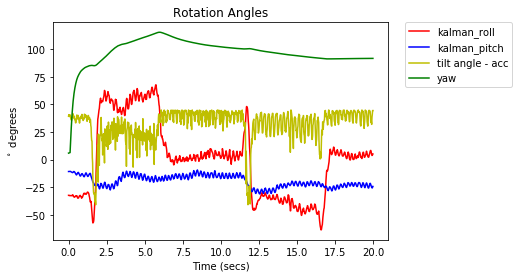

In [7]:
import matplotlib.pyplot as plt

df = vals_df

# Optional conversion
dt = 0.02 # 1/Sampling rate Hz
ts = df.ts * dt

# Plots

fig, ax = plt.subplots()

ax.plot(ts, df['kalman_roll'], color='r', label='kalman_roll')
ax.plot(ts, df['kalman_pitch'], color='b', label='kalman_pitch')
ax.plot(ts, df['acc_angle_z'], color='y', label='tilt angle - acc')
ax.plot(ts, df['yaw'], color='g', label='yaw')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlabel('Time (secs)')
ax.set_ylabel('$^\circ$ degrees')
plt.title('Rotation Angles')
plt.show(fig)
